## Basic Concepts in Machine Learning

<center>
<img src="images/overview.png" width="900">
</center>

This lecture will discuss the basic structure and concepts that underly machine learning models, and explore the various types of algorithms used in machine learning through prototype examples. Ultimately the `scikit-learn` python package and other useful programming tools will be introduced. 

* Programming tools
    - scikit-learn
    - scipy
    - autograd
* Machine learning basics:
    - The structure of a machine-learing model
    - Classes of models
    - Model complexity (hyperparameter selection)
    - Model parameter optimization (loss/objective function)
    - Model validation (cross validation)
    - Interpolation vs. Extrapolation
    - Local vs. Global models
* Mathematical background:
    - Linear vs. Non-linear models
    - Linear algebra
    - Numerical optimization
* Prototype algorithms
    - Generalized linear regression
    - kNN (classification)
    - k-means (clustering)
    - PCA (dimensional reduction)


## Programming tools

Machine learning algorithms can be complicated. Luckily, many implementations are openly available in Python through the `scikit-learn` package. There are [tutorials](http://scikit-learn.org/stable/tutorial/index.html) available, and plenty of pages with more [background info](https://machinelearningmastery.com/a-gentle-introduction-to-scikit-learn-a-python-machine-learning-library/).

In [1]:
from sklearn.linear_model import LinearRegression

The [optimization packages](https://docs.scipy.org/doc/scipy/reference/optimize.html) in `scipy` can also be very useful, especially when implementing your own machine learning algorithms.

In [2]:
from scipy.optimize import minimize

Finally, the `autograd` package provides [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) of python functions. This is a somewhat advanced feature that is generally beyond the scope of this course, but it is a very useful tool to know about.

In [3]:
import autograd.numpy as np   # autograd has its own "version" of numpy that must be used
from autograd import grad # the "grad" function provides derivatives

def position(t):
    s1 = 5
    s2 = 20
    s3 = 40
    if t < 10:
        pos = s1*t
    elif t < 15:
        pos = s2*t - 10*(s2-s1)
    else:
        pos = s3*t - 15*(s3-s2) - 10*(s2-s1)
    return pos

We can take the derivative of this function using `autograd`:

/home/aj/Software/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


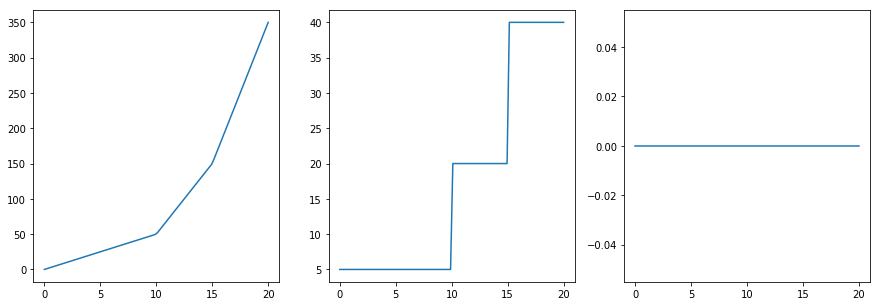

In [4]:
%matplotlib inline
import pylab as plt

t = np.linspace(0,20,100) # create a time series from 0-20 with 100 points
x = [position(ti) for ti in t]
speed = grad(position)
accel = grad(speed)
s = [speed(ti) for ti in t]
a = [accel(ti) for ti in t]

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(t,x)
axes[1].plot(t,s)
axes[2].plot(t,a)

Usually it is most efficient to use a model that is already implemented in `scikit-learn` (or other packages) in a practical scenario, but it is also useful to build your own versions of the algorithms to better understand how they work.

## Machine learning basics

### The structure of a machine-learning model

The goal of machine learning is to utilize only data to "learn" a relationship between an input and an output:

$\vec{y} = f(\vec{x})$

where $f$ is the model, $x$ is the model input and $y$ is the model output. The model inputs, $\vec{x}$ are often called the **features** of a data point. Sometimes the features are easy to obtain directly from the raw data (e.g. numerical attributes like concentration, temperature, pressure, etc.), but as we will see later in the course extracting features from raw data can be a challenge (e.g. images, audio, etc.). Features are "fingerprints" of raw input data.

Of course representing the model as $f$ is a gross oversimplification. The model needs:

* **parameters**, $\vec{W}$, that define its behavior (e.g. slope, intercept)
* **hyperparameters**, $\vec{\eta}$, that define the structure of the model (e.g. the number of polynomial terms)

Notably, $\vec{W}$ will depend on $\vec{\eta}$. So, we can be a little more specific:

$\vec{y} = f(\vec{x}, \vec{W}(\vec{\eta}))$

Machine learning seeks to optimize both $\vec{W}$ (parameter optimization) and $\vec{\eta}$ (complexity optimization) in order to obtain a model that generalizes to new input data.

In [5]:
import pandas as pd
example = pd.read_csv('datasets/example.csv')
example.head(10)

,x1,x2,class
0,0.273055,328.795581,0
1,0.797648,197.690321,0
2,0.956190,247.047065,0
3,1.043007,380.460727,0
4,1.430549,338.705346,0
5,1.575510,310.357404,0
6,1.116627,234.046671,0
7,1.421396,402.359107,0
8,1.373570,399.133828,0
9,1.516915,259.488743,0


Text(0,0.5,'y')

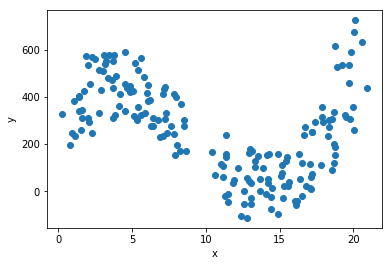

In [6]:
x = example['x1']
y = example['x2']
c = example['class']
fig,ax = plt.subplots()
ax.scatter(x,y)#,c=c)
ax.set_xlabel('x')
ax.set_ylabel('y')

### Classes of machine-learning models

$\vec{y} = f(\vec{x}, \vec{W}(\vec{\eta}))$

We can classify models based on a few criteria:

#### Supervised vs. Unsupervised

In a "supervised" model we have "training data" for $\vec{y}$, meaning that there are examples to define the pattern/relationship we are looking for.

In an "unsupervised" model $\vec{y}$ is determined by the structure of the inputs $\vec{x}$. This is not really intutive given the way $y=f(x)$ is written; another way of thinking about it is that we look for "inherent" patterns in $\vec{x}$ and those are our "outputs".

#### Supervised models: Classification and regression

Supervised models can be classified by the nature of their outputs. If the output $\vec{y}$ is a continuous variable then it is a **regression** model, while if it is a discrete (boolean, ordinal, integer, etc.) variable then it is a **classification** model.

#### Unsupervised models: Dimensional reduction and clustering

There are two main types of unsupervised learning. **Dimensional reduction** algorithms project high-dimensional (many parameters) inputs ($\vec{x}$) to a lower-dimensional space ($\vec{\tilde{x}}$, where len($\vec{\tilde{x}}$) < len($\vec{x}$)). **Clustering** algorithms assign labels/groups to data points based on similarity metrics. Clustering is like unsupervised classification.

### Example: Polynomial regression

$y = b + m*x + p*x^2 + ...$

$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4 + ...$

$y = \sum_i^N \beta_i x_i^i$

In [7]:
from sklearn.linear_model import LinearRegression

def polynomial_features(x, N):
    # function to return a matrix of polynomials for x to order N
    return np.array([x**k for k in range(0,N+1)]).T

X = polynomial_features(x, 4)
print(x.shape,X.shape, y.shape)

(179,) (179, 5) (179,)


The `scikit-learn` approach to polynomial regression is to build up a "feature space" of polynomial transforms of the original data, then use multi-linear regression. The common notation is to refer to the feature space as `X` and output as `y` for supervised models.

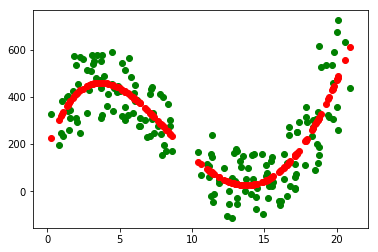

In [8]:
model = LinearRegression(fit_intercept=False)
model.fit(X,y) #<- "fit" the model (optimize the parameters beta_i)
yhat = model.predict(X) #<- get the model predictions (evaluate the optimized function)

fig, ax = plt.subplots()
ax.scatter(x,y, color='g') #<- plot the original data
ax.scatter(x,yhat,color='r')

 ### Model complexity
 
 $\vec{y} = f(\vec{x}, \vec{W}(\vec{\eta}))$
 
 The "complexity" of a model is defined by its hyperparameters ($\vec{\eta}$). The goal of machine learning is to **optimize the complexity** of a model so that it **generalizes to new examples**. In order to achieve this goal we first need a way to quantify complexity so that we can optimize it.
 
 In general there are a few strategies:
 
 * Number of parameters: "Complexity" varies linearly with number of parameters
 * Information criteria: "Complexity" varies logarithmically with number of parameters and is balanced with model accuracy.
 * "Smoothness": "Complexity" is related to the maximum curvature of the model
 
 "With four parameters I can fit an elephant, and with five I can make him wiggle his trunk."
 
 -- John Von Neumann
 
 (see an [example here](https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/))

### Model parameter optimization

The "parameters" of the model, $\vec{W}$, must also be determined. This is achieved through numerical and/or analytical optimization of a "loss function" or "objective function" ($L(\vec{W})$). This function defines the quality of the model.

Typical loss functions include:

* Sum of squared error (least-squares regression)
* Sum of squared error plus size of parameters (regularization)
* Mean absolute percentage error (neural networks)


In [9]:
SSE = sum((y-yhat)**2)
MAE = np.sqrt(SSE)/len(y)
MAE

7.470829698562262

### Model validation

We also need a strategy to see if our model will **generalize to new examples**. This is achieved by "cross-validation", where some examples ("test" examples) are hidden when the model is fit to "training" examples, and the loss function is assessed on the data that was hidden.

There are many strategies for cross-validation:

* hold-out: randomly leave out a percentage (usually ~30%) of the data during training.
* k-fold: select `k` (usually 3-5) randomly-assigned sub-groups of data, and train `k` times holding each group out.
* leave p out: leave `p` (usually 1) samples out of the training and assess the error for the `p` that were left out. Repeat for all possible `p` subsets of the sample.
* bootstrapping: random selection with replacement to generate a sample of the same size as the original dataset, with a number of repetitions.

Cross-validation is used to determine hyperparameters. In this case, even the "test" sets are used to optimize the model. It is common to select an additional "validation" or "holdout" subset for a final validation of the model.

Important (and often violated) assumption: **The collected data is representative of future data.**

MAE (test): 120.30674320888149


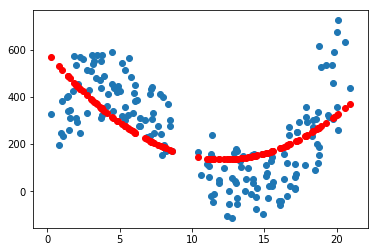

In [11]:
from sklearn.model_selection import train_test_split

N = 2
X = polynomial_features(x, N)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

model.fit(X_train,y_train) #<- "fit" the model with training data
yhat = model.predict(X_test) #<- get the model predictions for the test data

SSE = sum((y_test-yhat)**2)
MAE = np.sqrt(SSE/len(y)) #<- evaluate the loss function for the test data
print('MAE (test):', MAE)

fig, ax = plt.subplots()
ax.scatter(x,y) #<- plot the original data
ax.scatter(X_test[:,1],yhat,color='r')

### What is the value of the hyperparameter of the polynomial regression model that optimizes the complexity for this dataset?

### Interpolation vs. Extrapolation

In general, machine learning models can **only** interpolate. There are possible exceptions, but this requires some specialized model development and/or prior knowledge of the nature of the model.

"Extrapolation" with machine learning models is typically achieved through search/exploration algorithms or "adaptive learning". These algorithms utilize machine-learning models to produce an iterative experimental design scheme that involves collection of new data. This effectively turns extrapolation problems into interpolation problems.

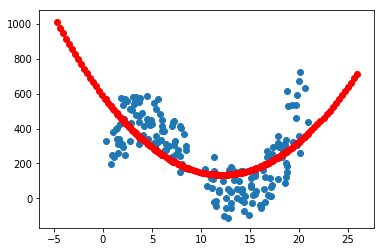

In [12]:
x_extrap = np.linspace(min(x)-5, max(x)+5, 100)
X_extrap = polynomial_features(x_extrap, N)

y_extrap = model.predict(X_extrap) #<- try to make a prediction out of original bounds

ax.scatter(X_extrap[:,1],y_extrap,color='r')
fig

### Parametric vs. Non-parametric

A "parametric" model has parameters that do not explicitly depend on or include the input space. The polynomial regression model is an example of a global model.

A "non-parametric" model includes some parameters or hyperparameters that are in the model inputs or defined on the domain of the independent variable. A spline model is an example of a local model.

Local models are generally excellent for interpolation, but fail miseraly for extrapolation, while global models are less accurate for interpolation but provide more reasonable extrapolations. Local models tend to have many more parameters, and proper optimization of model complexity can lead to similar performance for both types.

See [this post](https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/) for more information.

## Mathematical background

### Linear and non-linear models

<center>
<img src="images/convex.png" width="300">
<img src="images/nonconvex.png" width="300">
</center>

Linear models have a unique solution that can typically be obtained analytically and evaluated using linear algebra. Most linear models can be reduced to:

$ \underline{\underline{A}} \vec{x} = \vec{b} $

or, in summation notation:

$ \sum_i A_{ij} x_{i} = b_j $

Non-linear models have multiple optima, and are considerably more complex. They can be solved with a range of algorithms that are often applied directly to the objective function:

$\frac{\partial L(\vec{W})}{\partial \vec{W}} = 0$

Index notation can be useful for taking derivatives with respect to vectors:

$\frac{\partial L(W_j)}{\partial W_i} = 0$

This is the "Jacobian" ($J_i$) of the loss function. Many optimization algorithms also use the "Hessian" matrix:

$H_{ij} = \frac{\partial^2 L(W_k)}{\partial W_i \partial W_j}$

The "Jacobian" and "Hessian" are multi-dimensional first- and second-derivatives.

### A note on notation

The use of "index" or "summation" notation is common in machine learning, and makes implementation and vector calculus much more convenient. You should be comfortable with (at least) the standard "[vector notation](https://en.wikipedia.org/wiki/Vector_notation)" ($\underline{\underline{A}}$, $\vec{x}$) and "[index notation](https://en.wikipedia.org/wiki/Index_notation)" ($A_{ij}, x_i$). We will often switch between these notations, sometimes even within a single problem/derivation, so you should be comfortable with both.

If you are struggling with index notation [this post](https://math.stackexchange.com/questions/2063241/matrix-multiplication-notation) may help.

## Is polynomial regression a "linear" or "nonlinear" model? Is it "parametric" or "nonparametric"?

## Linear Algebra

You should already be famililar with linear algebra, but we will briefly review the basics and show how it works in `numpy` by covering the following:

Formulating your code as matrix-matrix and matrix-vector operations in Numpy will make it much more efficient. We will briefly cover syntax for:

* scalar*vector
* scalar*matrix
* matrix*vector
* matrix*matrix
* inverse
* solve Ax=b
* eigendecomposition

`numpy` notes:

* reshaping and resizing arrays
* boolean and comparison operators on arrays

### Scalar-array operations

We can use the usual arithmetic operators to multiply, add, subtract, and divide arrays with scalar numbers.

In [13]:
v1 = np.arange(0, 5)
print(v1)
print('-'*10)
print(v1*2)
print('-'*10)
print(v1+2)

[0 1 2 3 4]
----------
[0 2 4 6 8]
----------
[2 3 4 5 6]


Same goes for matrices:

In [14]:
M = np.random.rand(2,2)
print(M)
print('-'*10)
print(M*2)
print('-'*10)
print(M+2)

[[0.75063395 0.05454358]
 [0.64906029 0.65716829]]
----------
[[1.50126791 0.10908716]
 [1.29812058 1.31433657]]
----------
[[2.75063395 2.05454358]
 [2.64906029 2.65716829]]


### Element-wise array-array operations

When we add, subtract, multiply and divide arrays with each other, the default behaviour is **element-wise** operations. This is different from Matlab!

In [15]:
v1 = np.arange(2,6)
print(v1)
print(v1*v1)
print(v1/v1)

print('-'*10)

M = np.array([[1,2],[3,4]])
print(M)
print(M*M)

[2 3 4 5]
[ 4  9 16 25]
[1. 1. 1. 1.]
----------
[[1 2]
 [3 4]]
[[ 1  4]
 [ 9 16]]


### Matrix algebra

What about matrix mutiplication?

* use the `dot` function (recommended)
* use the `matrix` class (`+`, `*`, `-` use matrix algebra)

In [16]:
A = np.eye(3,3)
v = np.array([1,2,3])
print(np.dot(A,v))
print(np.dot(A,A))
print(np.dot(v,v))

A = np.matrix(A)
v = np.matrix(v)
print(A*v.T)
print(A*A)
print(v*v.T)

[1. 2. 3.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
14
[[1.]
 [2.]
 [3.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[14]]


### Common matrix operations

We can easily calculate the inverse and determinant using `inv` and `det`

In [17]:
A = np.array([[-1,2],[3,-1]])
print(A)
print(np.linalg.inv(A))
print(np.linalg.det(A))

[[-1  2]
 [ 3 -1]]
[[0.2 0.4]
 [0.6 0.2]]
-5.000000000000001


### Linear equation systems

Linear equation systems on the matrix form

$\underline{\underline{A}} \vec{x} = \vec{b}$

where $A$ is a matrix and $x,b$ are vectors can be solved like:

In [18]:
from  scipy.linalg  import solve

N = 3
A = np.random.rand(N,N)
b = np.random.rand(N)

x = solve(A, b)

print(x)
# check
np.dot(A, x) - b
np.isclose(np.dot(A,x),b)

[-6.15452473e-01  1.96896477e-03  5.52364529e+00]


array([ True,  True,  True])

We can also do the same with

$\underline{\underline{A}} \underline{\underline{X}} = \underline{\underline{B}}$

where $A, B, X$ are matrices:

In [19]:
A = np.random.rand(N,N)
B = np.random.rand(N,N)

X = solve(A, B)
# check
np.isclose(np.dot(A, X), B)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

### Exercise: Convince yourself that $\underline{\underline{A}} \underline{\underline{X}} = \underline{\underline{B}}$ is equivalent to solving `N` independent systems of the form $\underline{\underline{A}} \vec{x} = \vec{b}$.

### Eigenvalues and eigenvectors

The eigenvalue problem for a matrix $\underline{\underline{A}}$:

$\underline{\underline{A}} v_n = \lambda_n v_n$

where $v_n$ is the $n$th eigenvector and $\lambda_n$ is the $n$th eigenvalue.

To calculate eigenvalues of a matrix, use the `eigvals` function, and for calculating both eigenvalues and eigenvectors, use the function `eig`:

In [20]:
from scipy.linalg import eigvals, eig
evals = eigvals(A)
print(evals)

evals, evecs = eig(A)
print(evals)
print(evecs)

[ 1.3048706 +0.j -0.32168357+0.j  0.4354428 +0.j]
[ 1.3048706 +0.j -0.32168357+0.j  0.4354428 +0.j]
[[-0.78371417 -0.6576367   0.38289719]
 [-0.19620601  0.09284886 -0.79679445]
 [-0.58931765  0.74759151  0.46744877]]


The eigenvectors corresponding to the $n$th eigenvalue (stored in evals[n]) is the $n$th column in evecs, i.e., evecs[:,n]. To verify this, let's try mutiplying eigenvectors with the matrix and compare to the product of the eigenvector and the eigenvalue:

In [21]:
n = 1

np.dot(A, evecs[:,n]) - evals[n] * evecs[:,n]

array([-1.11022302e-16+0.j, -2.77555756e-17+0.j,  2.49800181e-16+0.j])

Eigendecompositions are very common in machine learning and data analysis, so you should brush up on this if you have forgotten what it means.

## Numpy notes:

### Reshaping and resizing arrays

The shape of an Numpy array can be modified without copying the underlaying data, which makes it a fast operation even for large arrays. There are rules that govern how this reshaping takes place.

In [ ]:
R = np.random.rand(3,3,3)
print(R.shape)
n,m,p = R.shape
Q = R.reshape((n, m*p))
print(Q.shape)
F = R.flatten() #the "flatten" function turns the whole array into a vector
print(F.shape)

Two common pitfalls in reshaping arrays:

* Reshaping rules do not behave as expected
* Reshaping provides a different "view" of the data, but **does not copy it**

In [ ]:
print(R[0,0,0])
print(F[0])
print(R[0,1,0])
print(F[1])
print(F[3])

In [ ]:
print(R[0,0,0])
Q[0] = 10
print(R[0,0,0]) #resize does not copy the data
F[0] = 6
print(R[0,0,0]) #flatten makes copies

### Making a "deep copy"

If you really want a copy of an array, use the `np.copy` function:

In [ ]:
A = np.array([[1, 2], [3, 4]])
print(A)
B = A
B[0,0] = 10
print(A)
Acopy = np.copy(A)
Acopy[1,1] = 6
print(A)

## Numerical optimization

Optimization (finding minima or maxima of a function) is a large field in mathematics, and optimization of complicated functions or in many variables can be rather involved. Here we will only look at a few very simple cases. For a more detailed introduction to optimization with SciPy see: http://scipy-lectures.github.com/advanced/mathematical_optimization/index.html

We can typically achieve good results using `scipy`'s built-in functions:

In [ ]:
def f(x):
    return 4*x**3 + (x-2)**2 + x**4

fig, ax  = plt.subplots()
x = np.linspace(-5, 3, 100)
ax.plot(x, f(x))

There are many types of optimizers available. We will use the common BFGS and CG optimizers here, but you can read more in the [documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html).

In [ ]:
from  scipy.optimize  import minimize

x_min = minimize(f, 0.5, method='BFGS')
x_min

A related problem is solving an equation, which can be achieved with the `fsolve` function:

In [ ]:
def g(x):
    return np.sin(3*x)*(1/x)

fig, ax  = plt.subplots(figsize=(10,4))
x = np.linspace(1, 10, 100)
ax.plot(x, g(x))

In [ ]:
from scipy.optimize import fsolve

ans = fsolve(g, 0)
ans

# Prototype algorithms

We will introduce a prototype for each class of algorithm with a derivation and/or custom implementation. These algorithms will be revisited later in the course (along with others).

## Generalized linear regression

## k Nearest Neighbors (classification)

## k means (clustering)

## Principal component analysis (dimensional reduction)